# Scaling TTI equations from Fletcher et al

In [1]:
# import dependencies
import devito as dv
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from examples.seismic.source import TimeAxis
from examples.seismic import RickerSource

## Transforming equations from 3d to 2d

Fletcher et al. 2009 defines a coupled PDE system from a P-SV TTI dispersion relation as:

$\frac{\partial^2 p}{\partial t^2} = v_{px}^2 H_2 p + \alpha v_{pz}^2 H_1 q + v_{sz}^2 H_1 (p - \alpha q)$

$\frac{\partial^2 q}{\partial t^2} = \frac{v_{pn}^2}{\alpha} H_2 p + v_{pz}^2 H_1 q - v_{sz}^2 H_2 \left( \frac{1}{\alpha} p - q \right)$

Where $v_{pz}$ is the P-wave velocity in the direction normal to the symmetry plane, $v_{pn} = v_{pz}\sqrt{1 + 2\delta}$ with $v_{pn}$ being the P-wave NMO velocity, $v_{px} = v_{pz}\sqrt{1 + 2\epsilon}$ with $v_{px}$ being the P-wave velocity in the symmetry plane, $v_{sz}$ is the SV velocity normal to the symmetry plane, $\delta$ and $\epsilon$ are anisotropy parameters defined by Thomsen 1986 and $\alpha$ is a non-zero scalar used to parameterise the equations. $H_1$ and $H_2$ are derivative operators defined as:

$H_1 = \sin^2\theta \cos^2\phi \frac{\partial^2}{\partial x^2} + \sin^2\theta \sin^2\phi \frac{\partial^2}{\partial y^2} + \cos^2\theta \frac{\partial^2}{\partial z^2} + \sin^2\theta \sin 2\phi \frac{\partial^2}{\partial x \partial y} + \sin 2\theta \sin\phi \frac{\partial^2}{\partial y \partial z} + \sin 2\theta \cos\phi \frac{\partial^2}{\partial x \partial z} $

$H_2 = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} + \frac{\partial^2}{\partial z^2} - H_1$

The operators above are three dimensional, so to solve the equations in two dimensions we set $\frac{\partial}{\partial y}$ and $\phi$ equal to zero. This leads to two dimensional derivative operators defined as:

$H'_1 = \sin^2\theta \frac{\partial^2}{\partial x^2} + \cos^2\theta \frac{\partial^2}{\partial z^2} + \sin 2\theta \frac{\partial^2}{\partial x \partial z} $

$H'_2 = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial z^2} - H'_1$

Using these two dimensional operators, we define a new set of coupled PDEs as:

$\frac{\partial^2 p}{\partial t^2} = v_{px}^2 H'_2 p + \alpha v_{pz}^2 H'_1 q + v_{sz}^2 H'_1 (p - \alpha q)$

$\frac{\partial^2 q}{\partial t^2} = \frac{v_{pn}^2}{\alpha} H'_2 p + v_{pz}^2 H'_1 q - v_{sz}^2 H'_2 \left( \frac{1}{\alpha} p - q \right)$

Below, we implement this 2d coupled system using a $v_{pz}$ of 3000m/s, a $v_{sz}$ of zero, $\epsilon$ of 0.24, $\delta$ of 0.1, $\theta$ of 45 degrees and an $\alpha$ of 1

In [2]:
# setting up a grid 
extent = (2000, 2000)
shape = (201, 201)
x = dv.SpaceDimension('x')
z = dv.SpaceDimension('z')
grid = dv.Grid(extent=extent, shape=shape, dimensions=(x, z))

# creating functions for the two pressure fields
p = dv.TimeFunction(name='p', grid=grid, space_order=8, time_order=2)
q = dv.TimeFunction(name='q', grid=grid, space_order=8, time_order=2)

# defining constants and calculating velocities
sigma = 0.1
epsilon = 0.24
theta = sp.pi/4
alpha = 1
vpz = 3
vpx = 3*np.sqrt(1+2*epsilon)
vpn = 3*np.sqrt(1+2*sigma)
vsz = 0


# defining derivative operator functions
def h1(function, theta):
    operator = sp.sin(theta)**2*function.dx2 + sp.cos(theta)**2*function.dz2 + sp.sin(2*theta)*function.dx.dz
    return operator

def h2(function, theta):
    operator = function.laplace - h1(function, theta)
    return operator

# defining equations
eq_p = p.dt2 - vpx**2*h2(p, theta) - alpha*vpz**2*h1(q, theta) - vsz**2*(h1(p, theta) - alpha*h1(q, theta))
eq_q = q.dt2 - (vpn**2/alpha)*h2(p, theta) - vpz**2*h1(q, theta) + vsz**2*((1/alpha)*h2(p, theta) - h2(q, theta))

# define dt using the cfl condition
vmax = vpx
dt = np.amin(grid.spacing)*0.6/vmax

# define a time range for the source term
t0 = 0
tn = 250
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# creating source term, f=0.03 kHz (30Hz)
src = RickerSource(name='src', grid=grid, f0=0.03, npoint=1, time_range=time_range)
# setting source to the middle of the grid
src.coordinates.data[:] = [1000., 1000.]

# injecting the source term to the pressure field, edit expr to vary source term
src_p = src.inject(field=p.forward, expr=src)
src_q = src.inject(field=q.forward, expr=src)

# defining stencils
stencil_p = dv.Eq(p.forward, dv.solve(eq_p, p.forward))
stencil_q = dv.Eq(q.forward, dv.solve(eq_q, q.forward))

# set up operator
op = dv.Operator([stencil_p, stencil_q] + src_p + src_q)
op(dt=dt)


Operator `Kernel` ran in 0.09 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.08439900000000007, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=6.999999999999999e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

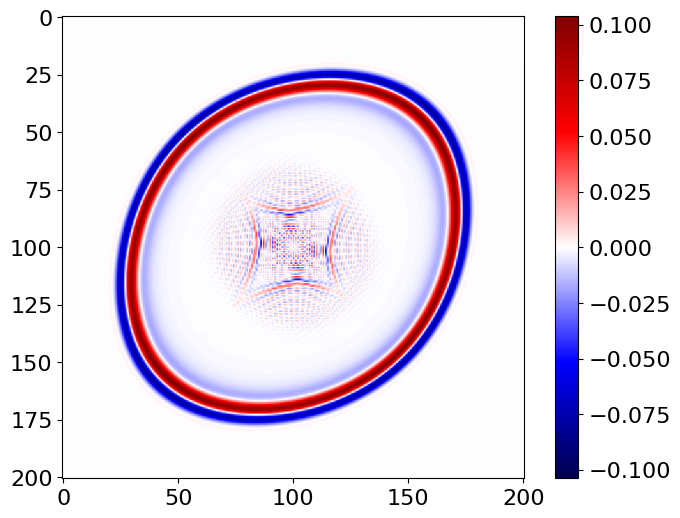

In [3]:
vmax = np.amax(np.abs(p.data[0]))
plt.imshow(p.data[0], cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

In [4]:
# setting up a new grid 
scaled_extent = (200, 200)
scaled_grid = dv.Grid(extent=scaled_extent, shape=shape, dimensions=(x, z))

# creating functions for the two scaled pressure fields
p_s = dv.TimeFunction(name='p_s', grid=scaled_grid, space_order=8, time_order=2)
q_s = dv.TimeFunction(name='q_s', grid=scaled_grid, space_order=8, time_order=2)

# defining constants and calculating velocities, scaling so the maximum is 1
sigma = 0.1
epsilon = 0.24
theta = sp.pi/4
alpha = 1
scaled_vpz = 3/(3*np.sqrt(1+2*epsilon))
scaled_vpx = 1
scaled_vpn = 3*np.sqrt(1+2*sigma)/(3*np.sqrt(1+2*epsilon))
vsz = 0

# defining equations
scaled_eq_p = p_s.dt2 - scaled_vpx**2*h2(p_s, theta) - alpha*scaled_vpz**2*h1(q_s, theta) - vsz**2*(h1(p_s, theta) - alpha*h1(q_s, theta))
scaled_eq_q = q_s.dt2 - (scaled_vpn**2/alpha)*h2(p_s, theta) - scaled_vpz**2*h1(q_s, theta) + vsz**2*((1/alpha)*h2(p_s, theta) - h2(q_s, theta))

# define new dt using the cfl condition
vmax = scaled_vpx
scaled_dt = np.amin(scaled_grid.spacing)*0.6/vmax

# define a new time range for the source term
t0 = 0
scaled_tn = 25*(3*np.sqrt(1+2*epsilon))
scaled_time_range = TimeAxis(start=t0, stop=scaled_tn, step=scaled_dt)

# creating source term, f=0.082 Hz 
scaled_src = RickerSource(name='src', grid=scaled_grid, f0=0.082, npoint=1, time_range=scaled_time_range)
# setting source to the middle of the grid
scaled_src.coordinates.data[:] = [100., 100.]

# injecting the source term to the pressure field, edit expr to vary source term
scaled_src_p = scaled_src.inject(field=p_s.forward, expr=scaled_src)
scaled_src_q = scaled_src.inject(field=q_s.forward, expr=scaled_src)

# defining stencils
scaled_stencil_p = dv.Eq(p_s.forward, dv.solve(scaled_eq_p, p_s.forward))
scaled_stencil_q = dv.Eq(q_s.forward, dv.solve(scaled_eq_q, q_s.forward))

# set up operator
new_op = dv.Operator([scaled_stencil_p, scaled_stencil_q] + scaled_src_p + scaled_src_q)
new_op(dt=scaled_dt)


Operator `Kernel` ran in 0.08 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.07810300000000012, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=4e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

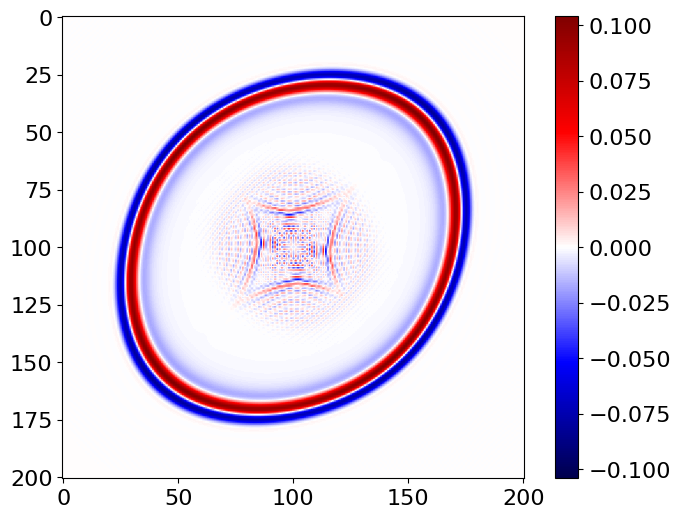

In [5]:
vmax = np.amax(np.abs(p_s.data[0]))
plt.imshow(p_s.data[0], cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()